# A Trading Strategy Based on Hidden Markov Model

In [35]:
import numpy as np
import pandas as pd
from matplotlib import cm
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM

### Data Loading

In [36]:
JPY = pd.read_csv('NYU_USD_JPY_2016_Fall2019.csv')
display(JPY.head())

,Ticker,Date,Price,Flow
0,USD/JPY_B,1/1/2016 17:00,120.1910,1.9446
1,USD/JPY_B,1/3/2016 18:00,120.2850,1.9000
2,USD/JPY_B,1/3/2016 19:00,120.3170,1.8705
3,USD/JPY_B,1/3/2016 20:00,120.3710,1.8811
4,USD/JPY_B,1/3/2016 21:00,120.0280,1.8993


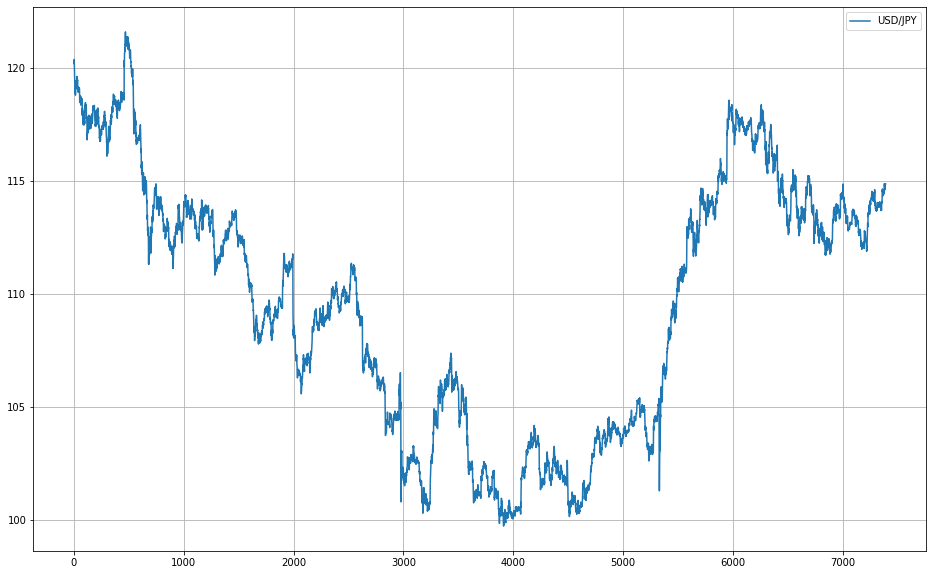

In [37]:
plt.figure(figsize=(16, 10))
JPY['Price'].plot(label='USD/JPY')
plt.legend(loc=0), plt.grid(True)
plt.show()

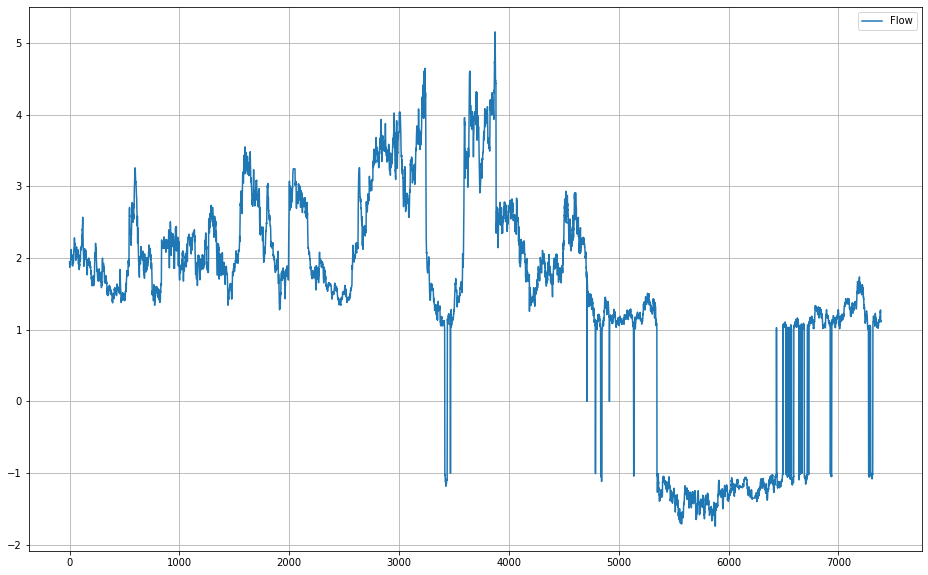

In [38]:
plt.figure(figsize=(16, 10))
JPY['Flow'].plot(label='Flow')
plt.legend(loc=0), plt.grid(True)
plt.show()

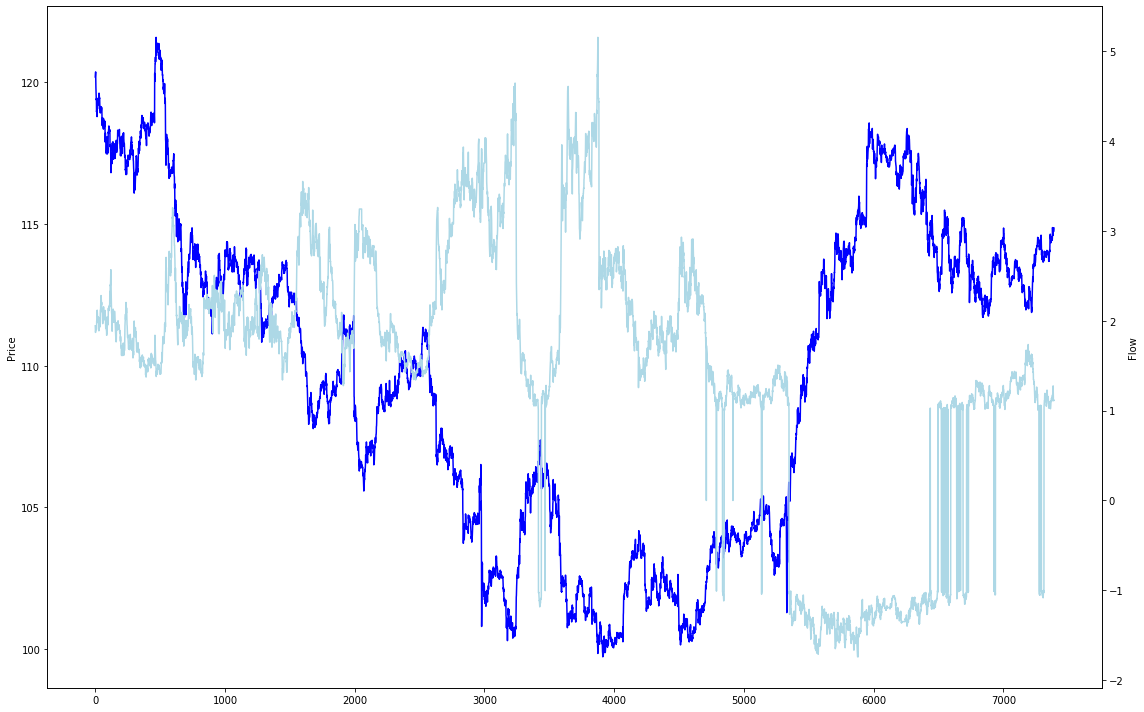

In [39]:
t = np.arange(len(JPY))

fig, ax1 = plt.subplots(figsize=(16, 10))
ax1.plot(t, JPY['Price'], color='blue')
ax1.set_ylabel('Price')

ax2 = ax1.twinx()
ax2.plot(t, JPY['Flow'], color='lightblue')
ax2.set_ylabel('Flow')
plt.tight_layout()
plt.show()

### Feature Engineering

In this part, we do some feature engineering to our original data 'Price' and 'Flow'.  
Use these features as input of Hidden Markov Model.  
In addition, we calculate 'future return' for each hour, we will not use this feature for HMM, but to distinguish different states.

In [40]:
def z_score(vals):
    # measure deviation relative to moving average, normalized by rolling standard deviation
    return (vals[-1] - np.mean(vals)) / np.std(vals)

def ma_ratio(vals):
    # deviation relative to moving average, normalized by moving average
    return (vals[-1] - np.mean(vals)) / np.mean(vals)

def normalized_std(vals):
    # rolling standard deviation, normalized moving average
    return np.std(vals) / np.mean(vals)

In [41]:
future_period = 1
rolling_period = 10

features = ['last_return', 'last_flow_change', 'price_deviation', 'flow_deviation', 'ma_ratio', 'normalized_std']
JPY['last_return'] = JPY['Price'].pct_change()
JPY['last_flow_change'] = JPY['Flow'].pct_change()
JPY['price_deviation'] = JPY['Price'].rolling(rolling_period).apply(z_score, raw=True)
JPY['flow_deviation'] = JPY['Flow'].rolling(rolling_period).apply(z_score, raw=True)
JPY['ma_ratio'] = JPY['Price'].rolling(rolling_period).apply(ma_ratio, raw=True)
JPY['normalized_std'] = JPY['Price'].rolling(rolling_period).apply(normalized_std, raw=True)

JPY['future_return'] = JPY['Price'].shift(-future_period) / JPY['Price'] - 1

JPY = JPY.replace([np.inf, -np.inf], np.nan)
JPY = JPY.dropna()
display(JPY.head())

,Ticker,Date,Price,Flow,last_return,last_flow_change,price_deviation,flow_deviation,ma_ratio,normalized_std,future_return
9,USD/JPY_B,1/4/2016 2:00,119.4260,1.9038,0.0003,0.0011,-1.3269,-0.1897,-0.0040,0.0030,-0.0039
10,USD/JPY_B,1/4/2016 3:00,118.9590,1.9073,-0.0039,0.0018,-1.8552,0.1280,-0.0069,0.0037,0.0004
11,USD/JPY_B,1/4/2016 4:00,119.0090,1.9965,0.0004,0.0468,-1.3919,2.3929,-0.0054,0.0039,-0.0011
12,USD/JPY_B,1/4/2016 5:00,118.8740,1.9810,-0.0011,-0.0078,-1.3836,1.5370,-0.0053,0.0039,0.0009
13,USD/JPY_B,1/4/2016 6:00,118.9820,1.9862,0.0009,0.0026,-1.0187,1.3579,-0.0033,0.0032,-0.0016


### Train Test Split

<Figure size 1440x720 with 0 Axes>

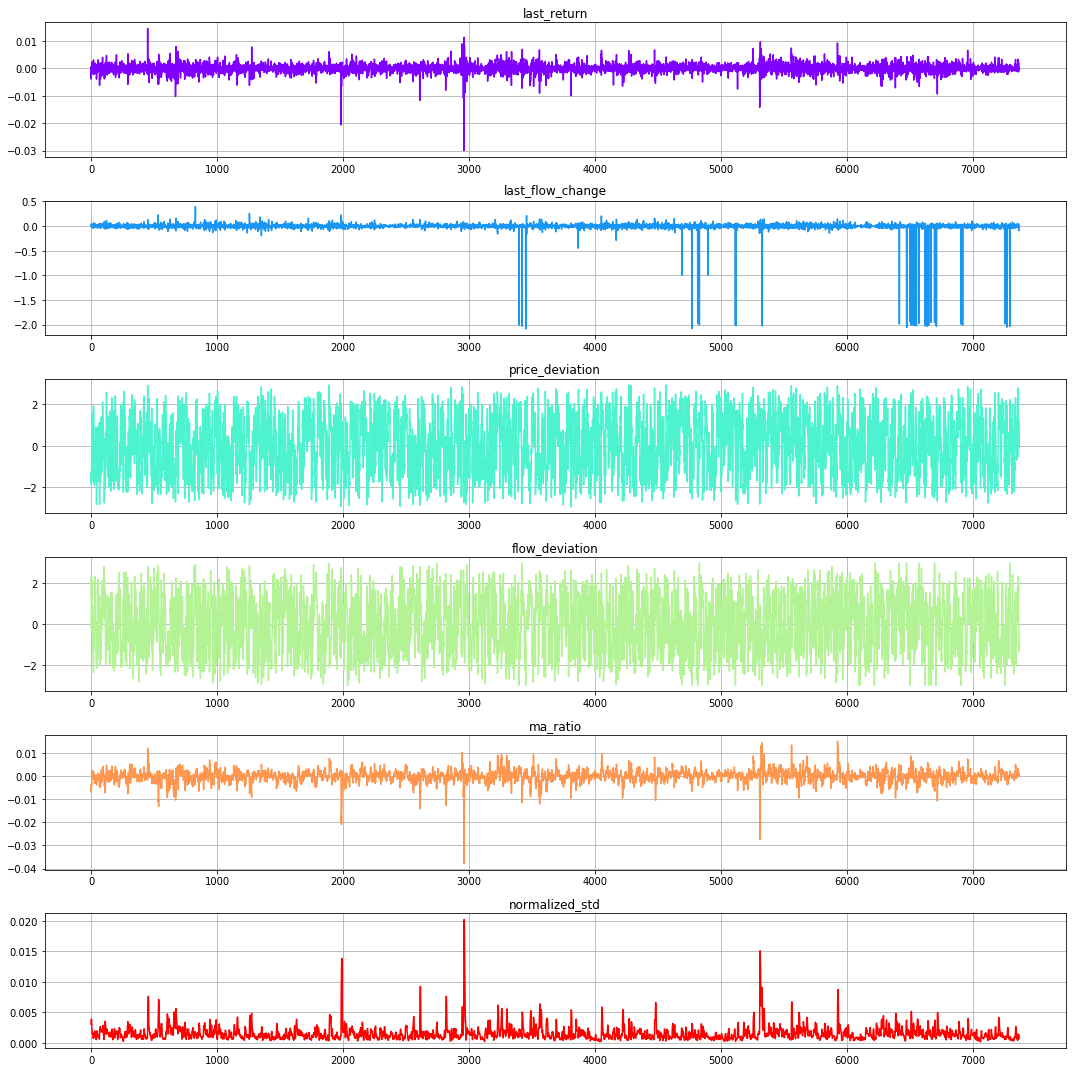

In [42]:
train_index = int(len(JPY) * 0.6)
train_set = JPY[features].values[:train_index]
test_set = JPY[features].values[train_index:]

# plots of each feeature over whole period
plt.figure(figsize=(20, 10))
fig, axs = plt.subplots(len(features), 1, figsize=(15, 15))
colors = cm.rainbow(np.linspace(0, 1, len(features)))
for i in range(len(features)):
    axs[i].plot(JPY.reset_index()[features[i]], color=colors[i])
    axs[i].set_title(features[i])
    axs[i].grid(True)
plt.tight_layout()

### HMM Model

In this part, we use train set features to train Hidden Markov Model for different numbers of states to obtain the optimal model.  
HMM assumes that market has different states and these states are not directly observable by us. Under certain state, market variables (features) has corresponding distributions and these features can be directly observed by us. So we are trying to infer hidden states using observable markets features.  
HMM is a kind of unsupervised learning and we try to gather the data points with similar features into certain states.

In [43]:
def get_best_model(X, max_states, max_iter=1000):
    best_score = -10000
    best_state = 0
    for state in range(1, max_states+1):
        hmm_model = GaussianHMM(n_components=state, random_state=100,
                                covariance_type='diag', n_iter=max_iter).fit(X)
        if hmm_model.score(X) > best_score:
            best_score = hmm_model.score(X)
            best_state = state
    best_model = GaussianHMM(n_components=best_state, random_state=100,
                             covariance_type='diag', n_iter=max_iter).fit(X)
    return best_model

In [44]:
model = get_best_model(train_set, max_states=5)
print(model)

GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
      covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
      min_covar=0.001, n_components=3, n_iter=1000, params='stmc',
      random_state=100, startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
      verbose=False)


In this part, we identify different states on the train set. We can see that the majority are the first two states.  
We also plot the distribution and cumulative sum of future returns for different states, we can see that cumsum of future returns have an upward trend for the first state, a downward trend for the second state and no specific trend for the last state.  
Based on the trend of future return at different states, we can build our trading strategy.

<Figure size 1080x1080 with 0 Axes>

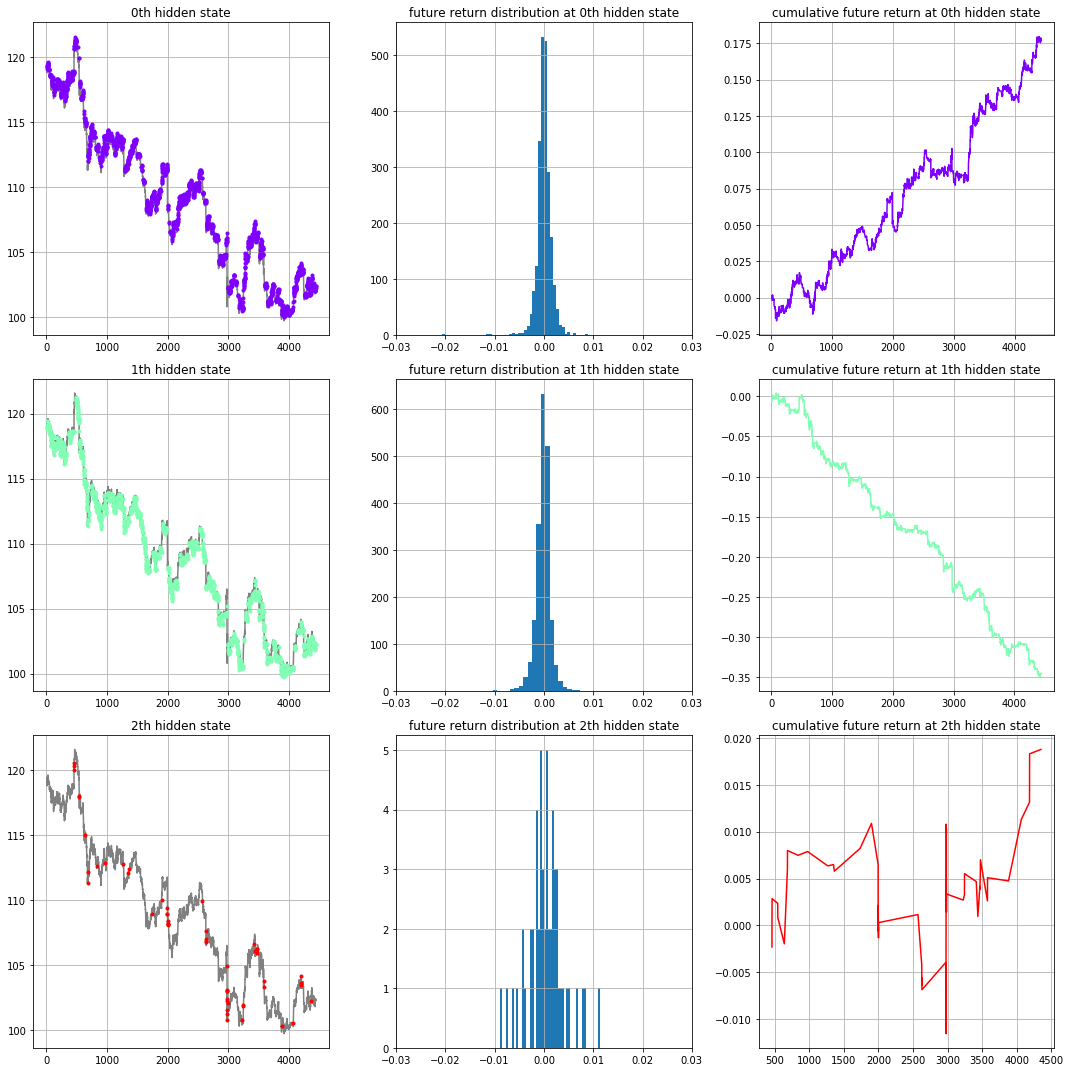

In [45]:
def plot_hidden_states(hmm_model, data, X):
    plt.figure(figsize=(15, 15))
    fig, axs = plt.subplots(hmm_model.n_components, 3, figsize=(15, 15))
    hidden_states = hmm_model.predict(X)
    colors = cm.rainbow(np.linspace(0, 1, hmm_model.n_components))
    for i, ax in enumerate(axs):
        mask = hidden_states == i
        ax[0].plot(data.index, data['Price'], c='grey')
        ax[0].plot(data.index[mask], data['Price'][mask], '.', c=colors[i])
        ax[0].set_title('{}th hidden state'.format(i))
        ax[0].grid(True)
            
        ax[1].hist(data['future_return'][mask], bins=50)
        ax[1].set_xlim([-0.03, 0.03])
        ax[1].set_title('future return distribution at {}th hidden state'.format(i))
        ax[1].grid(True)
            
        ax[2].plot(data['future_return'][mask].cumsum(), c=colors[i])
        ax[2].set_title('cumulative future return at {}th hidden state'.format(i))
        ax[2].grid(True)
    plt.tight_layout()
    plt.show()
    
plot_hidden_states(model, JPY[:train_index], train_set)

In this part, we generate sample features using our optimal Hidden Markov Model and plot the distribution for each feature at different states.  
We can observe a significant positive skewness of price deviation at the first state and a negative skewness of price deviation at the second state. This corresponds to the performance of future returns.

In [46]:
def compare_hidden_states(hmm_model, features, iters=1000):
    plt.figure(figsize=(15, 15))
    fig, axs = plt.subplots(len(features), hmm_model.n_components, figsize=(15, 15))
    colors = cm.rainbow(np.linspace(0, 1, hmm_model.n_components))
    for i in range(hmm_model.n_components):
        df = pd.DataFrame()
        for j in range(iters):
            row = hmm_model._generate_sample_from_state(i)
            df = df.append(pd.DataFrame(row).T)
        df.columns = features
        
        for k in range(len(features)):
            axs[k][i].hist(df[features[k]], bins=30, color=colors[i])
            axs[k][i].set_title('{0} distribution ({1}th state)'.format(features[k], i))
            axs[k][i].grid(True)
    plt.tight_layout()
    plt.show()

<Figure size 1080x1080 with 0 Axes>

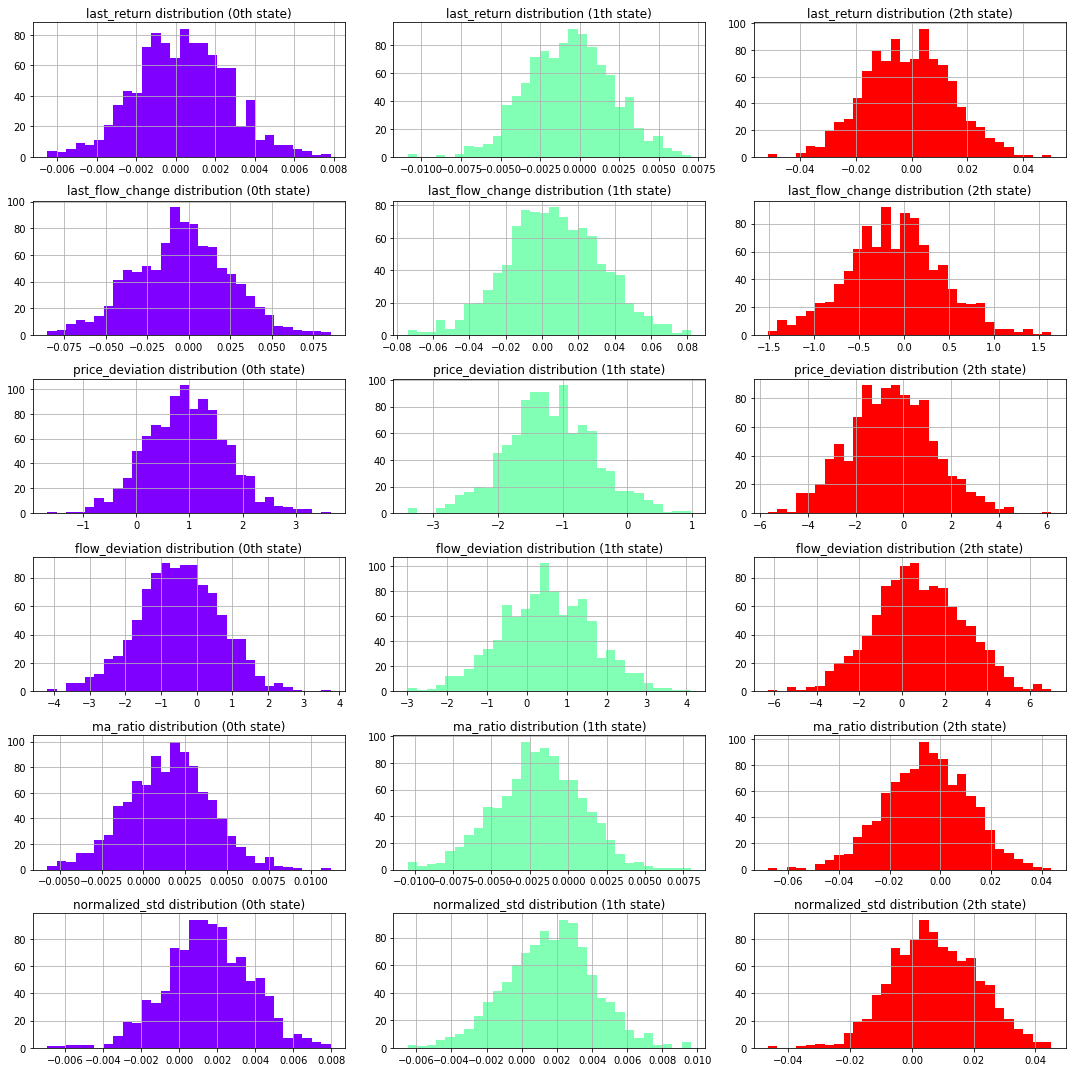

In [47]:
compare_hidden_states(model, features)

### Trading Strategy

In [48]:
def strategy(data, spread=0.01):
    '''
    Parameters
    ==========
    data : a dataframe object contain market price and trading signal
    spread : bid offer spread
    
    Returns
    =======
    PnL : an array object contains hourly PnL
    ret : an array object contains hourly return
    '''
    position = 0    # hourly position
    PnL = np.zeros(len(data))
    ret = np.zeros(len(data))
    PnL[0], ret[0] = 0, 0
    
    for i in range(len(data)-1):
        if data.iloc[i, 2] == 1:
            # Long signal
            if position == 0:
                # set long position and incur half b/o spread
                PnL[i+1] = -0.5 * spread
                ret[i+1] = PnL[i+1] / data.iloc[i, 0]
                position += 1
            elif position == 1:
                # hold the long position
                # PnL equals hourly value change of position
                PnL[i+1] = data.iloc[i+1, 0] - data.iloc[i, 0]
                ret[i+1] = PnL[i+1] / data.iloc[i, 0]
            elif position == -1:
                # liquidate short position and set long position
                # PnL equals hourly value change minus 2 half spread
                PnL[i+1] = data.iloc[i, 0] - data.iloc[i+1, 0] - 0.5 * spread * 2
                ret[i+1] = PnL[i+1] / data.iloc[i, 0]
                position += 2
            
        elif data.iloc[i, 2] == -1:
            # Short signal
            if position == 0:
                # set short position and incur half b/o spread
                PnL[i+1] = -0.5 * spread
                ret[i+1] = PnL[i+1] / data.iloc[i, 0]
                position -= 1
            elif position == -1:
                # hold the short position
                # PnL equals hourly value change
                PnL[i+1] = data.iloc[i, 0] - data.iloc[i+1, 0]
                ret[i+1] = PnL[i+1] / data.iloc[i, 0]
            elif position == 1:
                # liquidate long position and set short position
                # PnL equals hourly value change minus 2 half spread
                PnL[i+1] = data.iloc[i+1, 0] - data.iloc[i, 0] - 0.5 * spread * 2
                ret[i+1] = PnL[i+1] / data.iloc[i, 0]
                position -= 2
                
        elif data.iloc[i, 2] == 0:
            # Hold si
            if position == 0:
                PnL[i+1] = 0
            elif position == 1:
                PnL[i+1] = data.iloc[i+1, 0] - data.iloc[i, 0]
            elif position == -1:
                PnL[i+1] = data.iloc[i, 0] - data.iloc[i+1, 0]
            ret[i] = PnL[i] / data.iloc[i, 0]
    
    return PnL, ret

### Performance on Test Set

Here we generate trading signal for test set and run trading strategy.

In [49]:
test_order = pd.DataFrame()
test_order['mid'] = JPY[train_index:]['Price'].values
test_order.index = JPY[train_index:]['Date'].values
test_order['state'] = model.predict(test_set)
test_order['signal'] = test_order['state'].apply(lambda x: 1 if x==0 else (-1 if x==1 else 0))
display(test_order.head())
# invest in JPY, each trade worth $1
# state 0 buy and hold for the following same state
# state 1 sell and hold for the following same state
# state 2 hold

,mid,state,signal
9/18/2016 21:00,102.2400,1,-1
9/18/2016 22:00,102.1410,1,-1
9/18/2016 23:00,102.0790,1,-1
9/19/2016 0:00,102.0450,1,-1
9/19/2016 1:00,102.0360,1,-1


In [50]:
test_PnL, test_ret = strategy(test_order, spread=0.006)
test_res = test_order.copy()
test_res['PnL'] = test_PnL
test_res['ret'] = test_ret
test_res['benchmark'] = test_res['mid'].pct_change()
test_res = test_res.dropna()
test_res['diff'] = test_res.apply(lambda row: row['ret'] - row['benchmark'], axis=1)
display(test_res.head())

,mid,state,signal,PnL,ret,benchmark,diff
9/18/2016 22:00,102.1410,1,-1,-0.0030,-0.0000,-0.0010,0.0009
9/18/2016 23:00,102.0790,1,-1,0.0620,0.0006,-0.0006,0.0012
9/19/2016 0:00,102.0450,1,-1,0.0340,0.0003,-0.0003,0.0007
9/19/2016 1:00,102.0360,1,-1,0.0090,0.0001,-0.0001,0.0002
9/19/2016 2:00,102.0280,1,-1,0.0080,0.0001,-0.0001,0.0002


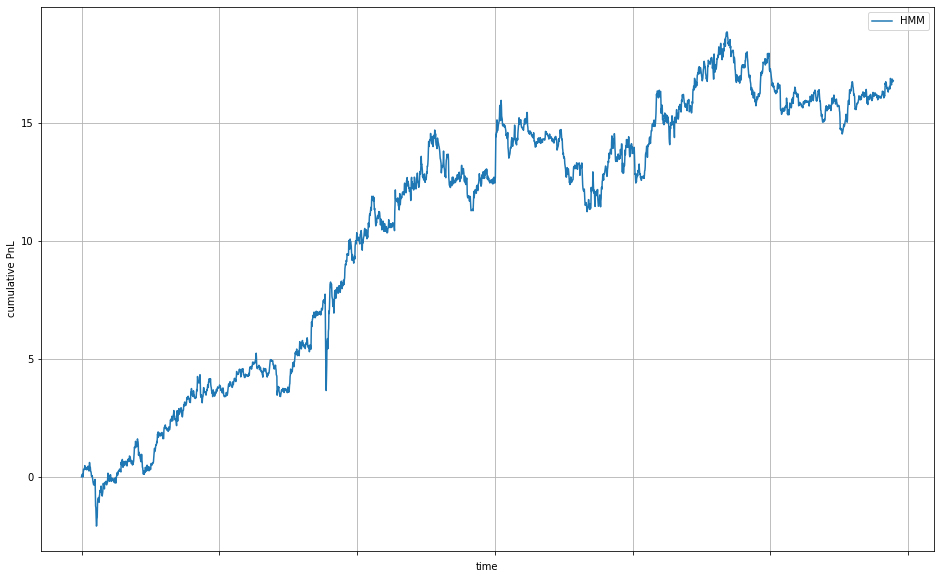

In [51]:
plt.figure(figsize=(16, 10))
test_res['PnL'].cumsum().plot(label='HMM')
plt.xlabel('time'), plt.ylabel('cumulative PnL')
plt.legend(loc=0), plt.grid(True)
plt.show()

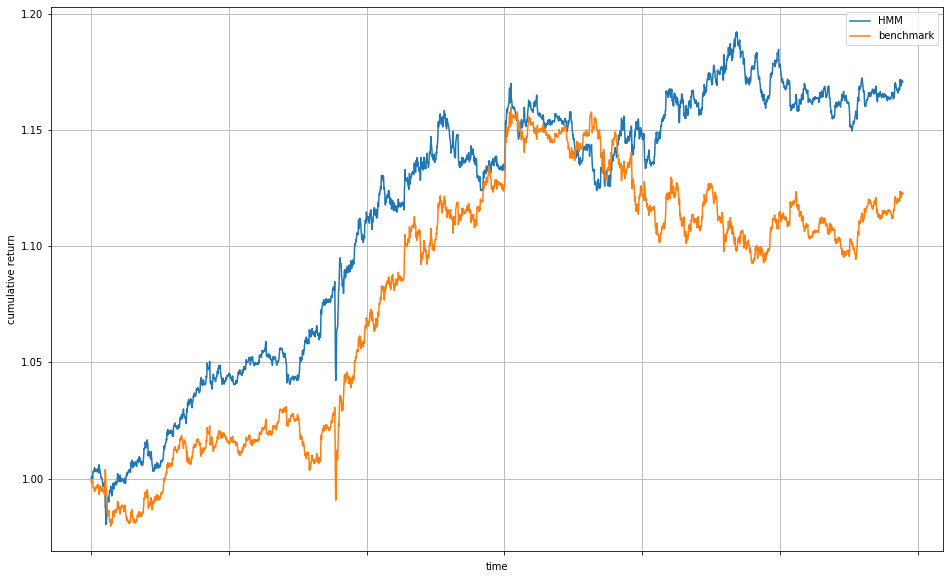

In [52]:
plt.figure(figsize=(16, 10))
(test_res['ret']+1).cumprod().plot(label='HMM')
(test_res['benchmark']+1).cumprod().plot(label='benchmark')
plt.xlabel('time'), plt.ylabel('cumulative return')
plt.legend(loc=0), plt.grid(True)
plt.show()

### Performance on Train Set

Here we generate trading signal for train set and run trading strategy.

In [53]:
train_order = pd.DataFrame()
train_order['mid'] = JPY[:train_index]['Price'].values
train_order.index = JPY[:train_index]['Date'].values
train_order['state'] = model.predict(train_set)
train_order['order'] = train_order['state'].apply(lambda x: 1 if x==0 else (-1 if x==1 else 0))
display(train_order.head())

,mid,state,order
1/4/2016 2:00,119.4260,1,-1
1/4/2016 3:00,118.9590,1,-1
1/4/2016 4:00,119.0090,1,-1
1/4/2016 5:00,118.8740,1,-1
1/4/2016 6:00,118.9820,1,-1


In [54]:
train_PnL, train_ret = strategy(train_order, spread=0.006)
train_res = train_order.copy()
train_res['PnL'] = train_PnL
train_res['ret'] = train_ret
train_res['benchmark'] = train_res['mid'].pct_change()
train_res = train_res.dropna()
train_res['diff'] = train_res.apply(lambda row: row['ret'] - row['benchmark'], axis=1)
display(train_res.head())

,mid,state,order,PnL,ret,benchmark,diff
1/4/2016 3:00,118.9590,1,-1,-0.0030,-0.0000,-0.0039,0.0039
1/4/2016 4:00,119.0090,1,-1,-0.0500,-0.0004,0.0004,-0.0008
1/4/2016 5:00,118.8740,1,-1,0.1350,0.0011,-0.0011,0.0023
1/4/2016 6:00,118.9820,1,-1,-0.1080,-0.0009,0.0009,-0.0018
1/4/2016 7:00,118.7930,1,-1,0.1890,0.0016,-0.0016,0.0032


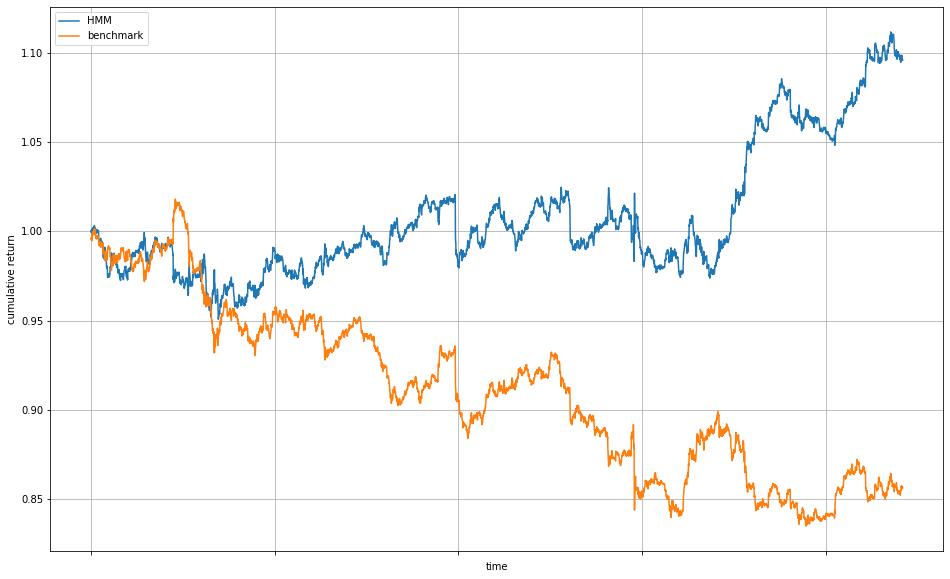

In [55]:
plt.figure(figsize=(16, 10))
(1+train_res['ret']).cumprod().plot(label='HMM')
(1+train_res['benchmark']).cumprod().plot(label='benchmark')
plt.xlabel('time'), plt.ylabel('cumulative return')
plt.legend(loc=0), plt.grid(True)
plt.show()

### Performance Stats

In [56]:
rf = 0.02
def calc_stats(data, name):
    ret_arr = data['ret'].values
    # calculate annualized return & volatility
    annual_ret = ret_arr.mean() * 24 * 6 * 52
    annual_vol = ret_arr.std() * np.sqrt(24 * 6 * 52)
    # calculate downside risk and Sortino Ratio
    downside_risk = np.array([x ** 2 if x<0 else 0 for x in ret_arr]).mean() ** 0.5 * np.sqrt(24 * 6 *52)
    sortino = (annual_ret - rf) / downside_risk
    # calculate Sharpe Ratio
    # expected return - financing cost / standard deviation
    sharpe = (annual_ret - rf) / annual_vol
    # calculate Information Ratio
    # excess return relative to benchmark / tracking error volatility
    IR = (data['diff'].mean() * 24 * 6 * 52) / (data['diff'].std() * np.sqrt(24 * 6 * 52))
    # calculate Win Ratio
    WR = (ret_arr > 0).sum() / len(ret_arr)
    # calculate maximum drawdown
    cum_ret = (1 + data['ret']).cumprod()
    drawdown = cum_ret / cum_ret.cummax() - 1
    abs_dd = drawdown.abs()
    max_dd = abs_dd.max()
    # calculate daily99 VaR
    index = int(len(data) * (1 - 0.99))
    # sort PnL values
    PnL_array = np.sort(data['PnL'].values)
    # interpolate hourly VaR
    hourly_VaR = PnL_array[index] + (len(data)*(1-0.99) - index) * (PnL_array[index+1] - PnL_array[index])
    # convert to daily VaR using square root of time rule
    daily_VaR = hourly_VaR * np.sqrt(24)
    
    result = pd.DataFrame(index=['annual return', 'annual vol', 'sharpe ratio', 'information ratio', 'sortino ratio',
                                 'win ratio', 'max drawdown', 'downside risk', 'Calmar ratio', 'daily99VaR'])
    result[name] = [annual_ret, annual_vol, sharpe, IR, sortino, WR, max_dd, downside_risk, (annual_ret / max_dd), abs(daily_VaR)]
    
    return result

In [57]:
test_stats = calc_stats(test_res, name='test')
pd.options.display.float_format = '{0:.4f}'.format
display(test_stats)

,test
annual return,0.4084
annual vol,0.1245
sharpe ratio,3.1194
information ratio,0.6883
sortino ratio,4.5658
win ratio,0.5022
max drawdown,0.0395
downside risk,0.0851
Calmar ratio,10.3368
daily99VaR,2.1265


In [58]:
train_stats = calc_stats(train_res, name='train')
display(train_stats)

,train
annual return,0.1646
annual vol,0.1372
sharpe ratio,1.0539
information ratio,2.0348
sortino ratio,1.5148
win ratio,0.4910
max drawdown,0.0523
downside risk,0.0954
Calmar ratio,3.1468
daily99VaR,2.2290


### Sensitivity Analysis

In [59]:
# compare stats on test set using different spreads
spreads = [0.002 * i for i in np.arange(0, 12, 2)]
bo_impact = pd.DataFrame()

for spread in spreads:
    res = test_order.copy()
    res['PnL'], res['ret'] = strategy(test_order, spread)
    res['benchmark'] = res['mid'].pct_change()
    res = res.dropna()
    res['diff'] = res.apply(lambda row: row['ret'] - row['benchmark'], axis=1)
    res_stats = calc_stats(res, name='spread={}'.format(spread))
    bo_impact = pd.concat([bo_impact, res_stats], axis=1)

Generally, performance stats become worse when we increase the spread.

In [60]:
display(bo_impact)

,spread=0.0,spread=0.004,spread=0.008,spread=0.012,spread=0.016,spread=0.02
annual return,0.4453,0.4207,0.3961,0.3715,0.3470,0.3224
annual vol,0.1244,0.1245,0.1246,0.1247,0.1248,0.1249
sharpe ratio,3.4198,3.2195,3.0194,2.8194,2.6198,2.4204
information ratio,0.9273,0.7680,0.6088,0.4497,0.2909,0.1322
sortino ratio,5.0177,4.7162,4.4158,4.1166,3.8186,3.5220
win ratio,0.5032,0.5029,0.5002,0.4998,0.4985,0.4971
max drawdown,0.0392,0.0392,0.0401,0.0413,0.0425,0.0437
downside risk,0.0848,0.0850,0.0852,0.0854,0.0856,0.0859
Calmar ratio,11.3576,10.7306,9.8744,8.9905,8.1572,7.3702
daily99VaR,2.1167,2.1213,2.1265,2.1265,2.1265,2.1265
